In [1]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [2]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_data = train_dataset.data
train_targets = train_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

print("Number of original training examples:", len(train_data))
print("Number of original test examples:", len(test_data))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
# Rescale the images to be between 0 and 1
train_data = train_data.float() / 255
test_data = test_data.float() / 255

In [4]:
# Print the shapes of the data
print(f"train_data.shape = {train_data.shape}")
print(f"test_data.shape = {test_data.shape}")

train_data.shape = torch.Size([60000, 28, 28])
test_data.shape = torch.Size([10000, 28, 28])


Create a function to filter out only 0 and 1

In [5]:
def filter_01(data, targets):
    indices = (targets == 0) | (targets == 1)
    data, targets = data[indices], targets[indices]
    targets = targets == 0
    return data, targets

train_data, train_targets = filter_01(train_data, train_targets)
test_data, test_targets = filter_01(test_data, test_targets)

print("Number of filtered training examples:", len(train_data))
print("Number of filtered test examples:", len(test_data))

Number of filtered training examples: 12665
Number of filtered test examples: 2115


Plot the original images

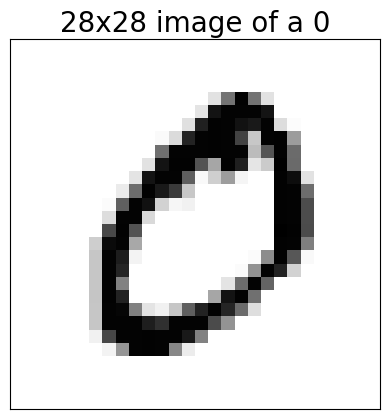

In [6]:
plt.imshow(train_data[0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 0", fontsize=20)
plt.show()

Reduce images to 9x9

In [7]:
train_data = torch.nn.functional.interpolate(train_data.unsqueeze(1).float(), size=(9, 9)).squeeze(1)
test_data = torch.nn.functional.interpolate(test_data.unsqueeze(1).float(), size=(9, 9)).squeeze(1)

print(f'train_data.shape = {train_data.shape}')
print(f'test_data.shape = {test_data.shape}')

train_data.shape = torch.Size([12665, 9, 9])
test_data.shape = torch.Size([2115, 9, 9])


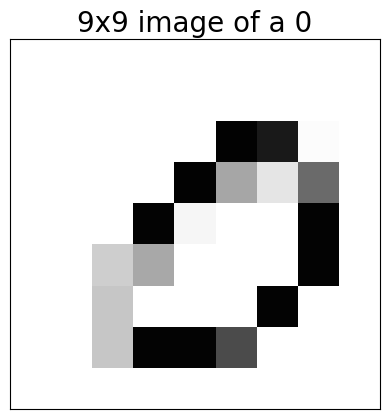

In [8]:
plt.imshow(train_data[0], vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x9 image of a 0", fontsize=20)
plt.show()

Further reduce images to 9x1

In [9]:
train_data = train_data[:, 4, :].reshape((-1, 9))
test_data = test_data[:, 4, :].reshape((-1, 9))
print(f"train_data.shape = {train_data.shape}")
print(f"test_data.shape = {test_data.shape}")

train_data.shape = torch.Size([12665, 9])
test_data.shape = torch.Size([2115, 9])


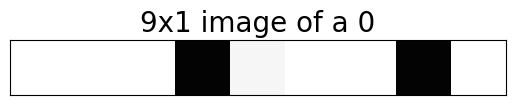

In [10]:
plt.imshow(train_data[0].reshape((1, -1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x1 image of a 0", fontsize=20)
plt.show()

## Set up the Quantum Neural Network

Create quantum circuit using pennylane qnode, then convert this to a PyTorch layer to make a PyTorch model

In [11]:
n_qubits = 9
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):

    if len(inputs.shape) == 1:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)
    else:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[:,ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3)}
print(weight_shapes)

{'weights': (1, 17, 3)}


In [12]:
class QNN(nn.Module):
    def __init__(self):
        super(QNN, self).__init__()
        self.quantum_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        x = self.quantum_layer(x)
        return x

In [13]:
model = QNN()
print(model)

QNN(
  (quantum_layer): <Quantum Torch Layer: func=qnode>
)


Redefine the classification values to match the Hinge loss

In [14]:
train_targets = 2.0 * train_targets - 1.0
test_targets = 2.0 * test_targets - 1.0

Define the hinge accuracy

In [15]:
def hinge_accuracy(y_true, y_pred):
    # Squeeze the tensors and compare each element to 0.0
    y_true = torch.squeeze(y_true) > 0.0
    y_pred = torch.squeeze(y_pred) > 0.0
    # Compare predicted and true values, cast to float, and compute the mean
    result = (y_true == y_pred).float()
    return torch.mean(result)

## Compile and train the model

Compile the model using the hinge loss and accuracy and the Adam optimiser

In [16]:
criterion = nn.HingeEmbeddingLoss(margin=1)
optimizer = optim.Adam(model.parameters())

Train the model over 20 epochs

In [17]:
EPOCHS = 25
BATCH_SIZE = 32
NUM_EXAMPLES_TRAIN = 2000
# NUM_EXAMPLES_TEST = 250

In [18]:
# Take only the first 1000 examples for training and 250 for testing
train_data, train_targets = train_data[:NUM_EXAMPLES_TRAIN], train_targets[:NUM_EXAMPLES_TRAIN]
# test_data, test_targets = test_data[:NUM_EXAMPLES_TEST], test_targets[:NUM_EXAMPLES_TEST]

print("Number of training examples:", len(train_data))
print("Number of test examples:", len(test_data))

Number of training examples: 2000
Number of test examples: 2115


In [19]:
train_loader = DataLoader(list(zip(train_data, train_targets)), batch_size=BATCH_SIZE, shuffle=True)

In [20]:
model_test_accs = []
quantum_params = []
for epoch in range(EPOCHS):
    losses = []
    model.train()
    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = -model(x_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Add values of all parameters to a list
        quantum_params.append([p.detach().numpy().copy() for p in model.parameters()])

    model.eval()
    with torch.no_grad():
        train_acc = hinge_accuracy(train_targets, model(train_data))
        test_acc = hinge_accuracy(test_targets, model(test_data))
        model_test_accs.append(test_acc.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Accuracy: {train_acc.item()}, Test Accuracy: {test_acc.item()}")

Epoch 1/25, Train Accuracy: 0.2980000078678131, Test Accuracy: 0.2950354516506195
Epoch 2/25, Train Accuracy: 0.6694999933242798, Test Accuracy: 0.6747044920921326
Epoch 3/25, Train Accuracy: 0.7055000066757202, Test Accuracy: 0.7044917345046997
Epoch 4/25, Train Accuracy: 0.7325000166893005, Test Accuracy: 0.7323877215385437


KeyboardInterrupt: 

In [21]:
quantum_params[0][0][0, 0]

array([3.1203825, 3.6083748, 1.4615623], dtype=float32)

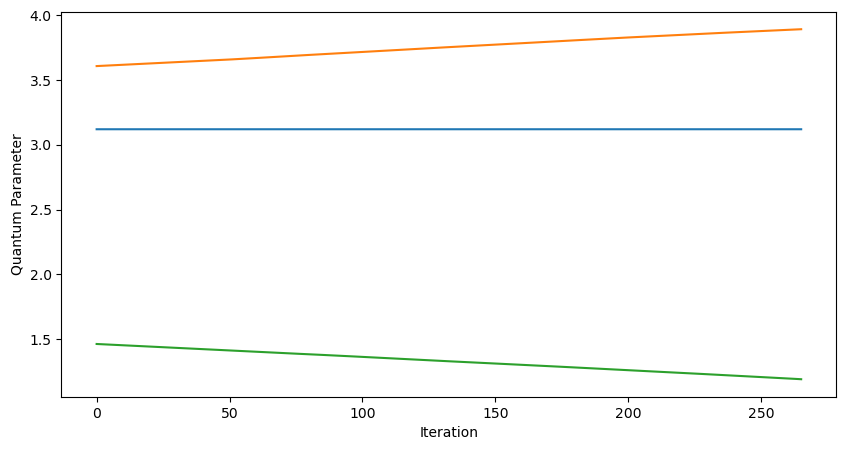

In [22]:
# Plot the quantum parameters over time
plt.figure(figsize=(10, 5))
plt.plot([p[0][0, 0] for p in quantum_params])
plt.xlabel("Iteration")
plt.ylabel("Quantum Parameter")
plt.show()

Create and train a 2 layer version of the QNN

In [86]:
n_layers = 2

@qml.qnode(dev, interface="torch")
def qnode2(inputs, weights):

    if len(inputs.shape) == 1:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)
    else:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[:,ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3)}

In [87]:
class QNN2(nn.Module):
    def __init__(self):
        super(QNN2, self).__init__()
        self.quantum_layer = qml.qnn.TorchLayer(qnode2, weight_shapes)

    def forward(self, x):
        x = self.quantum_layer(x)
        return x

In [88]:
model2 = QNN2()
print(model2)

QNN2(
  (quantum_layer): <Quantum Torch Layer: func=qnode2>
)


In [89]:
criterion = nn.HingeEmbeddingLoss()
optimizer = optim.Adam(model2.parameters())

In [90]:
model2_test_accs = []
for epoch in range(EPOCHS):
    losses = []
    model2.train()
    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = -model2(x_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model2.eval()
    with torch.no_grad():
        train_acc = hinge_accuracy(train_targets, model2(train_data))
        test_acc = hinge_accuracy(test_targets, model2(test_data))
        model2_test_accs.append(test_acc.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Accuracy: {train_acc.item()}, Test Accuracy: {test_acc.item()}")

Epoch 1/25, Train Accuracy: 0.20999999344348907, Test Accuracy: 0.22033096849918365
Epoch 7/25, Train Accuracy: 0.5099999904632568, Test Accuracy: 0.5163120627403259
Epoch 8/25, Train Accuracy: 0.5299999713897705, Test Accuracy: 0.5342789888381958
Epoch 9/25, Train Accuracy: 0.550000011920929, Test Accuracy: 0.5418439507484436
Epoch 2/25, Train Accuracy: 0.20999999344348907, Test Accuracy: 0.22033096849918365
Epoch 3/25, Train Accuracy: 0.23000000417232513, Test Accuracy: 0.22978723049163818
Epoch 4/25, Train Accuracy: 0.28999999165534973, Test Accuracy: 0.25153663754463196
Epoch 5/25, Train Accuracy: 0.5099999904632568, Test Accuracy: 0.479432612657547
Epoch 6/25, Train Accuracy: 0.5099999904632568, Test Accuracy: 0.5035461187362671
Epoch 10/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5498818159103394
Epoch 11/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5574468374252319
Epoch 12/25, Train Accuracy: 0.5799999833106995, Test Accuracy: 0.568794310092926
Epoch 13

## Hybrid Model

In [91]:
n_layers = 2
@qml.qnode(dev, interface="torch")
def qnode_h(inputs, weights):

    if len(inputs.shape) == 1:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)
    else:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[:,ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            qml.CNOT(wires=[ii+1,0])

        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3)}

In [92]:
class QNN_Hybrid(nn.Module):
    def __init__(self):
        super(QNN_Hybrid, self).__init__()

        self.pre_blocks = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
            nn.Sigmoid()
        )

        self.quantum_layer = qml.qnn.TorchLayer(qnode_h, weight_shapes)

        self.post_blocks = nn.Sequential(
            nn.Tanh()
        )

    def forward(self, x):
        x = self.pre_blocks(x)
        x = self.quantum_layer(x)
        x = self.post_blocks(x)
        return x

In [93]:
model_hybrid = QNN_Hybrid()
print(model_hybrid)
print(f"Number of parameters: {sum(p.numel() for p in model_hybrid.parameters())}")

QNN_Hybrid(
  (pre_blocks): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=9, bias=True)
    (3): Sigmoid()
  )
  (quantum_layer): <Quantum Torch Layer: func=qnode_h>
  (post_blocks): Sequential(
    (0): Tanh()
  )
)
Number of parameters: 453


In [94]:
criterion = nn.HingeEmbeddingLoss()
optimizer = optim.Adam(model_hybrid.parameters())

In [95]:
model_hybrid_test_accs = []
for epoch in range(EPOCHS):
    losses = []
    model_hybrid.train()
    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = -model_hybrid(x_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model_hybrid.eval()
    with torch.no_grad():
        train_acc = hinge_accuracy(train_targets, model_hybrid(train_data))
        test_acc = hinge_accuracy(test_targets, model_hybrid(test_data))
        model_hybrid_test_accs.append(test_acc.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Accuracy: {train_acc.item()}, Test Accuracy: {test_acc.item()}")

Epoch 1/25, Train Accuracy: 0.4300000071525574, Test Accuracy: 0.46335697174072266
Epoch 2/25, Train Accuracy: 0.4300000071525574, Test Accuracy: 0.46335697174072266
Epoch 3/25, Train Accuracy: 0.4300000071525574, Test Accuracy: 0.46335697174072266
Epoch 4/25, Train Accuracy: 0.4300000071525574, Test Accuracy: 0.46335697174072266
Epoch 5/25, Train Accuracy: 0.4300000071525574, Test Accuracy: 0.46335697174072266
Epoch 6/25, Train Accuracy: 0.699999988079071, Test Accuracy: 0.7612293362617493
Epoch 7/25, Train Accuracy: 0.8299999833106995, Test Accuracy: 0.8893616795539856
Epoch 8/25, Train Accuracy: 0.9399999976158142, Test Accuracy: 0.9390071034431458
Epoch 9/25, Train Accuracy: 0.9700000286102295, Test Accuracy: 0.9579195976257324
Epoch 10/25, Train Accuracy: 0.9300000071525574, Test Accuracy: 0.9697399735450745
Epoch 11/25, Train Accuracy: 0.9200000166893005, Test Accuracy: 0.93096923828125
Epoch 12/25, Train Accuracy: 0.8999999761581421, Test Accuracy: 0.9130023717880249
Epoch 13/25

## Hybrid Model with Compression

In [96]:
n_layers = 2
n_qubits = 3
@qml.qnode(dev, interface="torch")
def qnode_hc(inputs, weights):

    if len(inputs.shape) == 1:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)
    else:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[:,ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            qml.CNOT(wires=[ii+1,0])

        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3)}

In [97]:
class QNN_Hybrid_Compressed(nn.Module):
    def __init__(self):
        super(QNN_Hybrid_Compressed, self).__init__()

        self.pre_blocks = nn.Sequential(
            nn.Linear(9, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
            nn.Sigmoid()
        )

        self.quantum_layer = qml.qnn.TorchLayer(qnode_hc, weight_shapes)

        self.post_blocks = nn.Sequential(
            nn.Tanh()
        )

    def forward(self, x):
        x = self.pre_blocks(x)
        x = self.quantum_layer(x)
        x = self.post_blocks(x)
        return x

In [98]:
model_hybrid_compressed = QNN_Hybrid_Compressed()
print(model_hybrid_compressed)

QNN_Hybrid_Compressed(
  (pre_blocks): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
    (5): Sigmoid()
  )
  (quantum_layer): <Quantum Torch Layer: func=qnode_hc>
  (post_blocks): Sequential(
    (0): Tanh()
  )
)


In [99]:
criterion = nn.HingeEmbeddingLoss()
optimizer = optim.Adam(model_hybrid_compressed.parameters())

In [100]:
model_hybrid_compressed_test_accs = []
for epoch in range(EPOCHS):
    losses = []
    model_hybrid_compressed.train()
    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()
        y_pred = -model_hybrid_compressed(x_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model_hybrid_compressed.eval()
    with torch.no_grad():
        train_acc = hinge_accuracy(train_targets, model_hybrid_compressed(train_data))
        test_acc = hinge_accuracy(test_targets, model_hybrid_compressed(test_data))
        model_hybrid_compressed_test_accs.append(test_acc.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Accuracy: {train_acc.item()}, Test Accuracy: {test_acc.item()}")

Epoch 1/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 2/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 3/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 4/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 5/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 6/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 7/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 8/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 9/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 10/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 11/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 12/25, Train Accuracy: 0.5699999928474426, Test Accuracy: 0.5366430282592773
Epoch 13/25, 

## Plot the results!

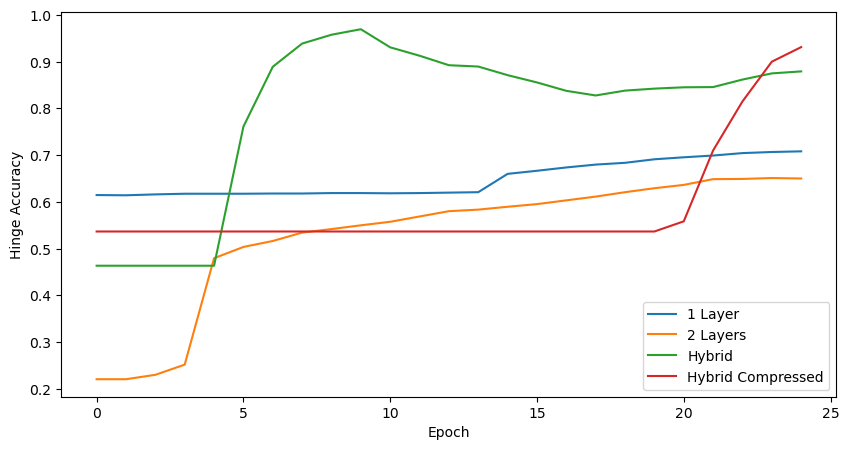

In [101]:
# Plot the hinge accuracy for the QNN history for both 1 and 2 layer on the same axes
plt.figure(figsize=(10, 5))
plt.plot(model_test_accs, label="1 Layer")
plt.plot(model2_test_accs, label="2 Layers")
plt.plot(model_hybrid_test_accs, label="Hybrid")
plt.plot(model_hybrid_compressed_test_accs, label="Hybrid Compressed")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
plt.show()


In [102]:
# Compare the ratio of test accuracy to number of parameters
model_efficiency = model_test_accs[-1] / sum(p.numel() for p in model.parameters())
model2_efficiency = model2_test_accs[-1] / sum(p.numel() for p in model2.parameters())
model_hybrid_efficiency = model_hybrid_test_accs[-1] / sum(p.numel() for p in model_hybrid.parameters())
model_hybrid_compressed_efficiency = model_hybrid_compressed_test_accs[-1] / sum(p.numel() for p in model_hybrid_compressed.parameters())

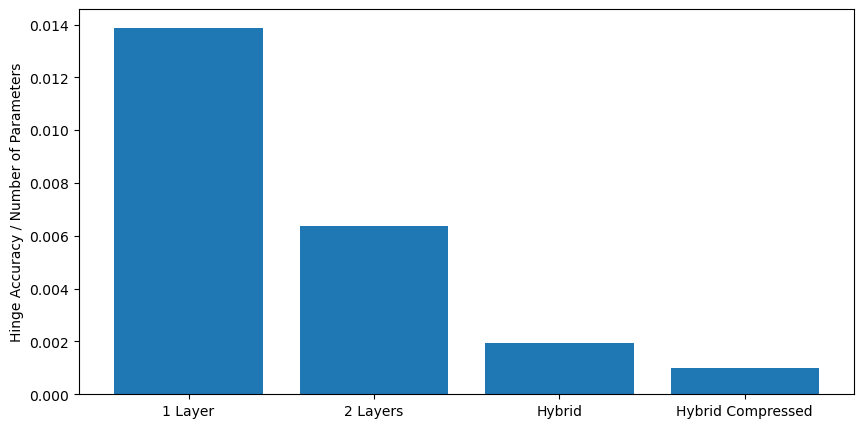

In [103]:
# Plot the efficiency of the models
plt.figure(figsize=(10, 5))
plt.bar(["1 Layer", "2 Layers", "Hybrid", "Hybrid Compressed"], [model_efficiency, model2_efficiency, model_hybrid_efficiency, model_hybrid_compressed_efficiency])
plt.ylabel("Hinge Accuracy / Number of Parameters")
plt.show()